  Rank   Size          Domain       Subdomain        Location
  ----   ----          ------       ---------        --------
     0      1    (32, 32, 32)    (32, 32, 32)       (0, 0, 0)


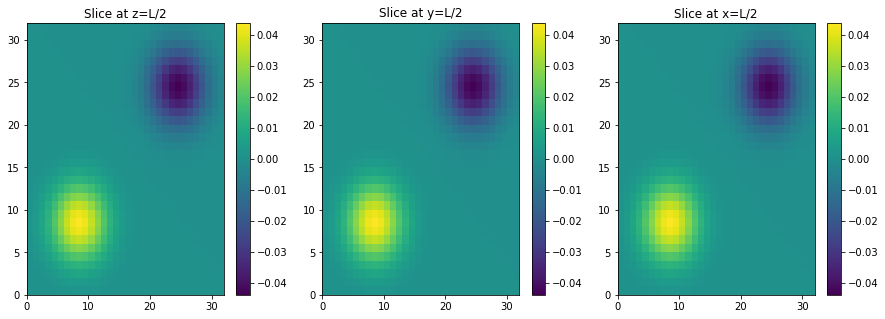

(32, 32, 32)


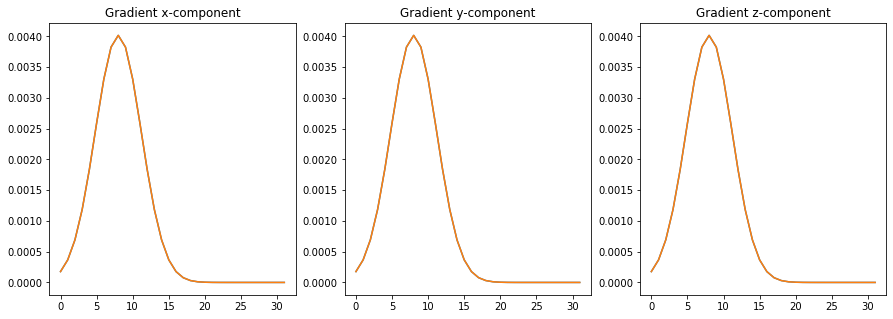

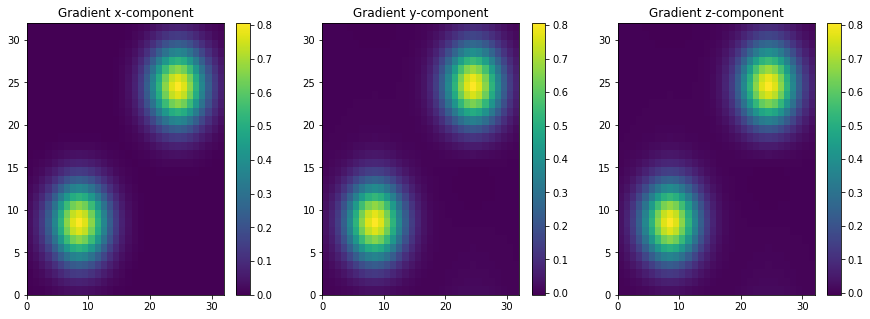

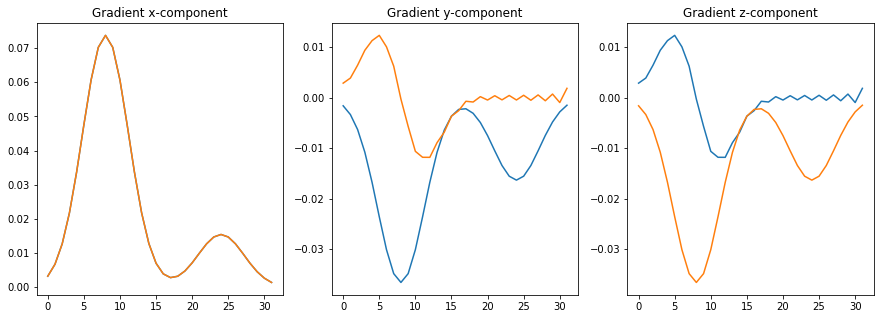

AttributeError: '_muFFT.PocketFFT' object has no attribute 'real_field_collection'

In [2]:
%matplotlib inline
import numpy as np
from mpi4py import MPI
from muGrid import FileIONetCDF, OpenMode, Communicator
from muFFT import FFT
import matplotlib.pyplot as plt

# Instantiate a FFT object with the PocketFFT engine
nb_grid_pts = (32, 32, 32)
physical_sizes = (2, 2, 2)  # Sizes of the domain (in arbitrary units)
nx, ny, nz = nb_grid_pts
lx, ly, lz = physical_sizes
fft = FFT(nb_grid_pts, engine='mpi', communicator=MPI.COMM_WORLD)

if MPI.COMM_WORLD.rank == 0:
    print('  Rank   Size          Domain       Subdomain        Location')
    print('  ----   ----          ------       ---------        --------')
MPI.COMM_WORLD.Barrier()  # Barrier so header is printed first

print(f'{MPI.COMM_WORLD.rank:6} {MPI.COMM_WORLD.size:6} {str(fft.nb_domain_grid_pts):>15} {str(fft.nb_subdomain_grid_pts):>15} {str(fft.subdomain_locations):>15}')

# Define the 3D domain
L = 1.0
N = 32

dt = 1e-4
num_steps = 1

# Define spherical heat sources and sinks
def spherical_heat_source_sink(X, Y, Z, L, radius=0.1):
    center_source = np.array([L/4, L/4, L/4])
    center_sink = np.array([3*L/4, 3*L/4, 3*L/4])
    source = np.exp(-np.sum((np.stack((X,Y,Z), axis=-1) - center_source) ** 2, axis=-1) / (2 * radius ** 2))
    sink = -np.exp(-np.sum((np.stack((X,Y,Z), axis=-1) - center_sink) ** 2, axis=-1) / (2 * radius ** 2))
    return source + sink


# Define the thermal diffusivity alpha
alpha = 1.0

# Obtain a real field and fill it
rfield = fft.real_space_field('scalar-field')
x, y, z = fft.coords
rfield.p = spherical_heat_source_sink(x, y, z, L)

# Compute Fourier transform
ffield = fft.fourier_space_field('scalar-field')
fft.fft(rfield, ffield)

# Compute Fourier gradient by multiplying with wavevector
fgrad = fft.fourier_space_field('gradient-field', (3,))
fgrad.p = 2 * np.pi * 1j * fft.fftfreq * ffield.p
# Solve for the Fourier coefficients of the temperature field


# Inverse transform to get gradient in real space
rgrad = fft.real_space_field('gradient-field', (3,))
fft.ifft(fgrad, rgrad)

# Normalize gradient
gradx, grady, gradz = rgrad.p * fft.normalisation
gradx *= nx / lx  # Need to multiply with inverse grid spacing
grady *= ny / ly  # Need to multiply with inverse grid spacing
gradz *= nz / lz  # Need to multiply with inverse grid spacing



# plot with matplotlib

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.pcolormesh(rfield.p[:, :, N//2])
plt.colorbar()
plt.title('Slice at z=L/2')
plt.subplot(1, 3, 2)
plt.pcolormesh(rfield.p[:, N//2, :])
plt.colorbar()
plt.title('Slice at y=L/2')
plt.subplot(1, 3, 3)
plt.pcolormesh(rfield.p[N//2, :, :])
plt.colorbar()
plt.title('Slice at x=L/2')
plt.show()



# plot gradient

print(gradx.shape)

local_num = 0

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(rfield.p[local_num, 15, :])
plt.plot(rfield.p[local_num, :, 15])
plt.title('Gradient x-component')
plt.subplot(1, 3, 2)
plt.plot(rfield.p[local_num, 15, :])
plt.plot(rfield.p[local_num, :, 15])
plt.title('Gradient y-component')
plt.subplot(1, 3, 3)
plt.plot(rfield.p[local_num, 15, :])
plt.plot(rfield.p[local_num, :, 15])
plt.title('Gradient z-component')
plt.show()



plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.pcolormesh(gradx[local_num, :, :])
plt.colorbar()
plt.title('Gradient x-component')
plt.subplot(1, 3, 2)
plt.pcolormesh(grady[:, local_num, :])
plt.colorbar()
plt.title('Gradient y-component')
plt.subplot(1, 3, 3)
plt.pcolormesh(gradz[:, :, local_num])
plt.colorbar()
plt.title('Gradient z-component')
plt.show()


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(gradx[local_num, 15, :])
plt.plot(gradx[local_num, :, 15])
plt.title('Gradient x-component')
plt.subplot(1, 3, 2)
plt.plot(grady[local_num, 15, :])
plt.plot(grady[local_num, :, 15])
plt.title('Gradient y-component')
plt.subplot(1, 3, 3)
plt.plot(gradz[local_num, 15, :])
plt.plot(gradz[local_num, :, 15])
plt.title('Gradient z-component')
plt.show()



file = FileIONetCDF('example.nc', open_mode=OpenMode.Overwrite, communicator=Communicator(MPI.COMM_WORLD))
file.register_field_collection(fft.real_field_collection)
file.append_frame().write()